In [1]:
# Modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sns

# Feature Selection
import xgboost as xgb
from sklearn.decomposition import PCA

# Evaluate Algorithms

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
from acquire_prepare import acquire_oil
from acquire_prepare import prep_data

import model
from model import polynomial_regression_model
from model import run_models

import numpy as np
import pandas as pd

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import sys 

**Let's bring in the DataFrame**

In [3]:
df = acquire_oil()
df = prep_data(df)

**(Rows, Columns)**

In [4]:
df.shape

(7808, 62)

### Use LabelEncoder to encode county and frak_fluid_type

In [7]:
encoder = LabelEncoder()

encoder.fit(df.county)
num_df['county'] = encoder.transform(df.county)

num_df.head()

,proppant_ppf,frac_fluid_gpf,gross_perfs,frac_stages,oil_gravity,peak_boepd,gor_hist,ip90_boeqpd,tvd,months_active,...,scaled_frac_fluid_gpf,scaled_gross_perfs,scaled_frac_stages,scaled_oil_gravity,scaled_gor_hist,scaled_tvd,scaled_mid_point_lat,scaled_mid_point_long,scaled_vintage,county
30,1311.78809,1642.58887,3977.0,0.0,0.0,61.408554,1738.53259,47.452900,10021.0,33,...,0.547863,0.292627,0.000000,0.0,0.087056,0.745943,0.614855,0.580622,0.966667,0
31,1088.56238,1493.36900,7283.0,0.0,0.0,416.961182,1381.57100,351.796700,9764.0,66,...,0.498082,0.536127,0.000000,0.0,0.069179,0.726813,0.517410,0.581774,0.916667,0
32,951.97060,1369.34363,7382.0,0.0,0.0,838.371765,1961.41300,688.525400,10798.0,64,...,0.456706,0.543419,0.000000,0.0,0.098218,0.803781,0.587606,0.571086,0.916667,0
33,1155.36267,1299.68433,7382.0,31.0,0.0,438.325684,1325.53870,406.427765,9506.0,63,...,0.433468,0.543419,0.442857,0.0,0.066373,0.707608,0.592304,0.570250,0.916667,0
34,1284.25537,1596.72742,7050.0,0.0,0.0,443.969543,2816.79077,289.934052,10138.0,59,...,0.532564,0.518966,0.000000,0.0,0.141055,0.754652,0.576165,0.563362,0.933333,0


In [8]:
encoder = LabelEncoder()
encoder.fit(df.frac_fluid_type)
num_df['frac_fluid_type'] = encoder.transform(df.frac_fluid_type)
num_df.head()

,proppant_ppf,frac_fluid_gpf,gross_perfs,frac_stages,oil_gravity,peak_boepd,gor_hist,ip90_boeqpd,tvd,months_active,...,scaled_gross_perfs,scaled_frac_stages,scaled_oil_gravity,scaled_gor_hist,scaled_tvd,scaled_mid_point_lat,scaled_mid_point_long,scaled_vintage,county,frac_fluid_type
30,1311.78809,1642.58887,3977.0,0.0,0.0,61.408554,1738.53259,47.452900,10021.0,33,...,0.292627,0.000000,0.0,0.087056,0.745943,0.614855,0.580622,0.966667,0,7
31,1088.56238,1493.36900,7283.0,0.0,0.0,416.961182,1381.57100,351.796700,9764.0,66,...,0.536127,0.000000,0.0,0.069179,0.726813,0.517410,0.581774,0.916667,0,3
32,951.97060,1369.34363,7382.0,0.0,0.0,838.371765,1961.41300,688.525400,10798.0,64,...,0.543419,0.000000,0.0,0.098218,0.803781,0.587606,0.571086,0.916667,0,0
33,1155.36267,1299.68433,7382.0,31.0,0.0,438.325684,1325.53870,406.427765,9506.0,63,...,0.543419,0.442857,0.0,0.066373,0.707608,0.592304,0.570250,0.916667,0,3
34,1284.25537,1596.72742,7050.0,0.0,0.0,443.969543,2816.79077,289.934052,10138.0,59,...,0.518966,0.000000,0.0,0.141055,0.754652,0.576165,0.563362,0.933333,0,7


### Standardize Numeric Data

In [9]:
scaled_df = num_df.copy()

scaled_df['proppant_ppf'] = (scaled_df.proppant_ppf - scaled_df.proppant_ppf.min()) / (scaled_df.proppant_ppf.max() - scaled_df.proppant_ppf.min())
scaled_df['frac_fluid_gpf'] = (scaled_df.frac_fluid_gpf - scaled_df.frac_fluid_gpf.min()) / (scaled_df.frac_fluid_gpf.max() - scaled_df.frac_fluid_gpf.min())
scaled_df['tvd'] = (scaled_df.tvd - scaled_df.tvd.min()) / (scaled_df.tvd.max() - scaled_df.tvd.min())
scaled_df['frac_stages'] = (scaled_df.frac_stages - scaled_df.frac_stages.min()) / (scaled_df.frac_stages.max() - scaled_df.frac_stages.min())
scaled_df['oil_gravity'] = (scaled_df.oil_gravity - scaled_df.oil_gravity.min()) / (scaled_df.oil_gravity.max() - scaled_df.oil_gravity.min())
scaled_df['peak_boepd'] = (scaled_df.peak_boepd - scaled_df.peak_boepd.min()) / (scaled_df.peak_boepd.max() - scaled_df.peak_boepd.min())
scaled_df['gor_hist'] = (scaled_df.gor_hist - scaled_df.gor_hist.min()) / (scaled_df.gor_hist.max() - scaled_df.gor_hist.min())
scaled_df['ip90_boeqpd'] = (scaled_df.ip90_boeqpd - scaled_df.ip90_boeqpd.min()) / (scaled_df.ip90_boeqpd.max() - scaled_df.ip90_boeqpd.min())
scaled_df['months_active'] = (scaled_df.months_active - scaled_df.months_active.min()) / (scaled_df.months_active.max() - scaled_df.months_active.min())
scaled_df['vintage'] = (scaled_df.vintage - scaled_df.vintage.min()) / (scaled_df.vintage.max() - scaled_df.vintage.min())

In [10]:
xgb_df = scaled_df.copy()

### XGBoost Feature Recommender

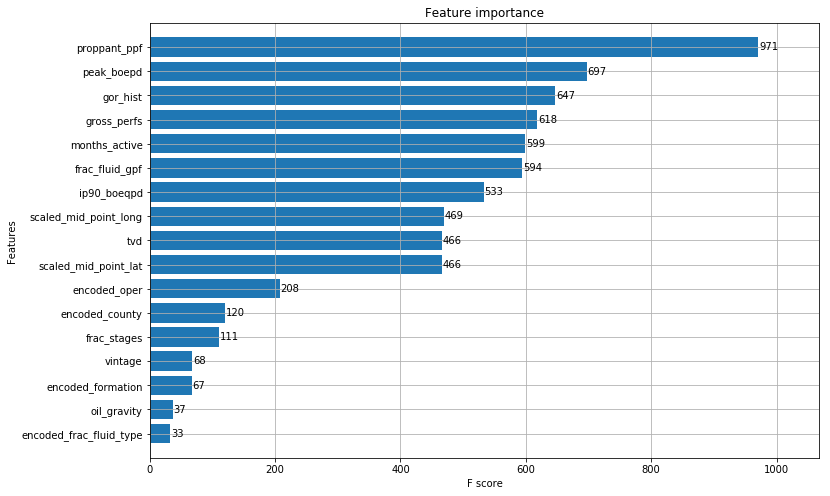

In [11]:
xgb_params = {
    'max_depth': 8,
    'seed' : 493
}

dtrain = xgb.DMatrix(xgb_df, df.oil_hist, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

# Test Harness and Options

In [5]:
# xfeatures = ['proppant_ppf', 'frac_fluid_gpf', 'gor_hist', 'tvd', 'mid_point_lat', 'mid_point_long', 'encoded_oper', 'encoded_direction', 'vintage', 'gross_perfs']
# yfeature = ['recovery']

In [6]:
xfeatures = ['proppant_ppf', 'gross_perfs', 'tvd', 'frac_fluid_gpf', 'gor_hist', 'encoded_oper', 'vintage']
yfeature = ['recovery']

In [7]:
def normalize(columns):
    for col in columns:
        df[col] = np.sqrt(df[col])
    return df

In [8]:
df_normalize = normalize(xfeatures)

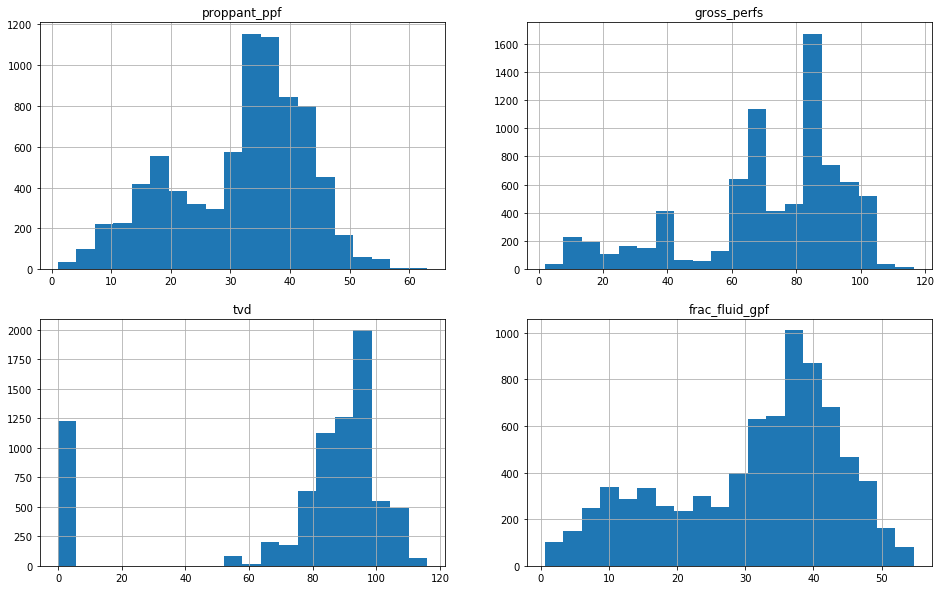

In [9]:
plt.figure(figsize=(16, 10))

for i, col in enumerate(['proppant_ppf', 'gross_perfs', 'tvd', 'frac_fluid_gpf']):  
    plot_number = i + 1 # i starts at 0, but plot nos should start at 1
    series = df_normalize[col]  
    plt.subplot(2, 2, plot_number)
    plt.title(col)
    series.hist(bins=20)

### Results for the entire dataframe to use as a baseline before clustering

Logistic Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 107.71021871400986
R2 score of training set is 0.23759234696326825


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.21250496 0.23098114 0.26413251]


The model performance for the test set
-------------------------------------------
RMSE of test set is 106.92262997246839
R2 score of test set is 0.2136081691318944




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 106.7949256907979
R2 score of training set is 0.2504947705515681


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.22517141 0.2454071  0.27485417]


The model performance for the test set
-------------------------------------------
RMSE of test set is 1

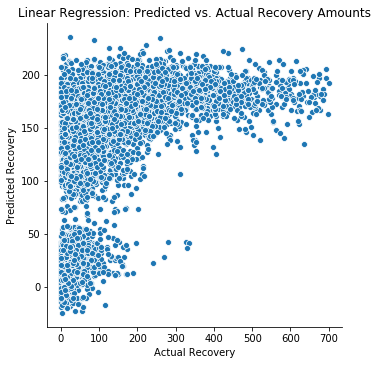

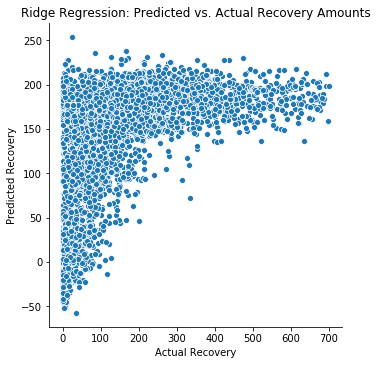

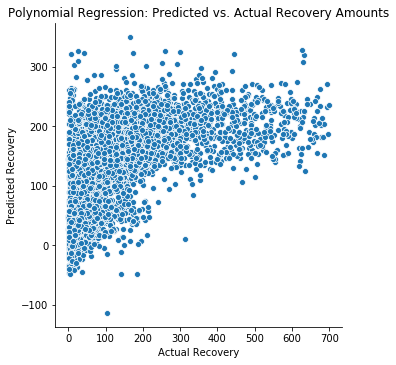

In [10]:
model.run_models(df_normalize, xfeatures, yfeature, 0.80)

**Let's Cluster by our Top Seven features per our XGBoost function**

In [11]:
# col_list = ['scaled_proppant_ppf', 'scaled_gross_perfs', 'scaled_tvd', 'scaled_frac_fluid_gpf', 
#             'scaled_gor_hist', 'encoded_oper', 'scaled_vintage']

In [12]:
col_list = ['proppant_ppf', 'gross_perfs', 'tvd', 'frac_fluid_gpf', 
            'gor_hist', 'encoded_oper', 'vintage']

**We now have a new dataframe with an added column "cluster_id"**

In [13]:
df = model.create_kclusters(df, col_list, 3, 'cluster_id')

**Let's see how many oberservations we have in each cluster**

In [14]:
df.cluster_id.value_counts()

0    4862
2    1714
1    1232
Name: cluster_id, dtype: int64

In [15]:
df.to_excel('CapstoneDataFinal.xlsx')

# ALL Regression Types on Each Cluster

### Cluster 0: 5,268 Oberservations 

In [16]:
cluster_zero = df[df['cluster_id'] == 0]

Logistic Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 116.4324157324041
R2 score of training set is 0.15132121484628314


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.15869842 0.1377222  0.14687557]


The model performance for the test set
-------------------------------------------
RMSE of test set is 114.42459922864703
R2 score of test set is 0.1459120128883168




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 116.38348219705188
R2 score of training set is 0.1520344204655758


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.15877928 0.13870807 0.14721634]


The model performance for the test set
-------------------------------------------
RMSE of test set is 1

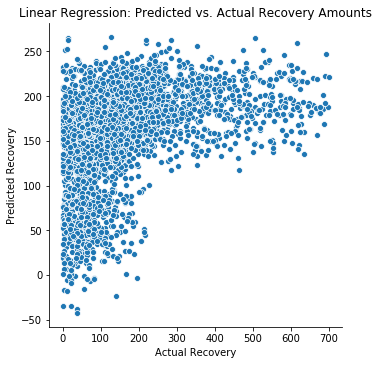

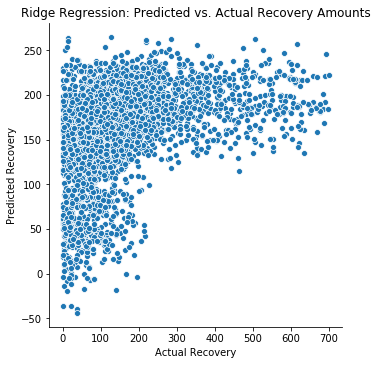

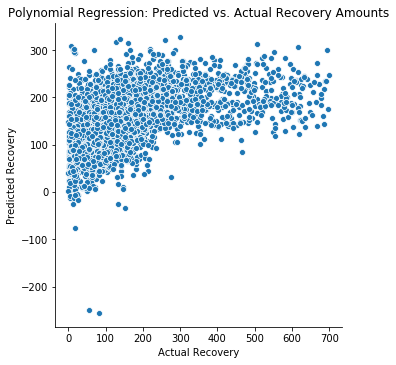

In [17]:
model.run_models(cluster_zero, xfeatures, yfeature, 0.70)

### Cluster 1: 1,360 Observations

In [18]:
cluster_one = df[df['cluster_id'] == 1]

Logistic Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 41.68368763824535
R2 score of training set is 0.15483454351202863


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [ 0.17355919 -0.02831587  0.13119352]


The model performance for the test set
-------------------------------------------
RMSE of test set is 31.34212967775091
R2 score of test set is 0.09201747365120916




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 36.584812371866136
R2 score of training set is 0.3489548067017769


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.32107788 0.21214034 0.31337609]


The model performance for the test set
-------------------------------------------
RMSE of test set i

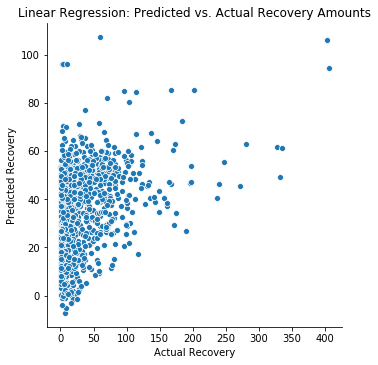

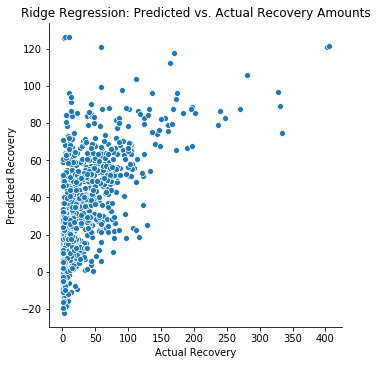

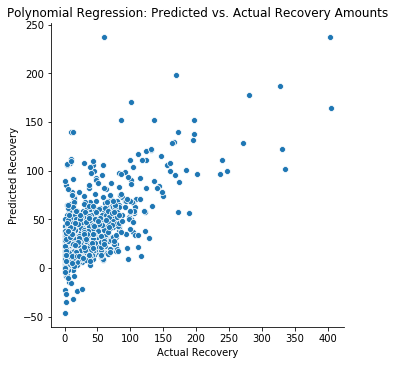

In [19]:
model.run_models(cluster_one, xfeatures, yfeature, 0.70)

### Cluster 2: 1,180 Observations

In [20]:
cluster_two = df[df['cluster_id'] == 2]

Logistic Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 98.51555460298324
R2 score of training set is 0.17843890288724118


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.18578542 0.17609334 0.12824802]


The model performance for the test set
-------------------------------------------
RMSE of test set is 109.1738547898237
R2 score of test set is 0.055514236034643116




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 98.15680794252282
R2 score of training set is 0.18441147572430616


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.19047612 0.18095269 0.13286746]


The model performance for the test set
-------------------------------------------
RMSE of test set is 

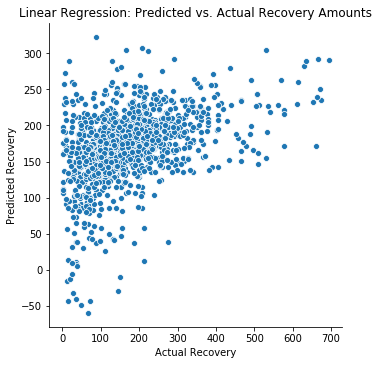

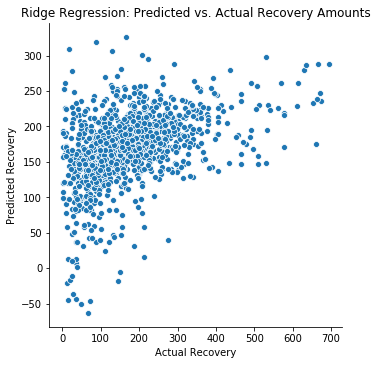

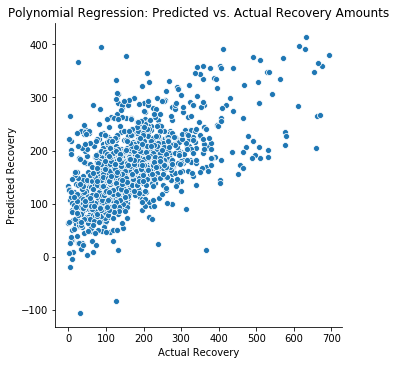

In [21]:
model.run_models(cluster_two, xfeatures, yfeature, 0.70)

## Interpret and report results

# Improve Results

## Algorithm Tuning

## Ensemble Methods

### Bagging

### Boosting

### Blending

## Extreme Feature Engineering